# Trying out almond kernel for scala

In [8]:
import $ivy.`com.lihaoyi::upickle:0.7.5`
import $ivy.`com.lihaoyi::os-lib:0.3.0`

import $ivy.$                           

import $ivy.$                          

## Reading the data

In [24]:
val resource_root_path: os.Path = os.root / "home"/ "jovyan" / "work" / "src" / "main" / "resources" / "MagicTheGathering"

resource_root_path: os.Path = /home/jovyan/work/src/main/resources/MagicTheGathering

In [29]:
val cards = ujson.read(os.read(resource_root_path / "AllCards.json")).obj
val prices = ujson.read(os.read(resource_root_path / "AllPrices.json")).obj
println(cards.head)
println(prices.head)

("Ach! Hans, Run!",{"colorIdentity":["G","R"],"colors":["G","R"],"convertedManaCost":6,"foreignData":[],"layout":"normal","legalities":{},"manaCost":"{2}{R}{R}{G}{G}","name":"\"Ach! Hans, Run!\"","printings":["UNH"],"purchaseUrls":{"cardmarket":"https://mtgjson.com/links/6227e6c981cce27c","tcgplayer":"https://mtgjson.com/links/85b366724beadefd"},"rulings":[],"scryfallOracleId":"a2c5ee76-6084-413c-bb70-45490d818374","subtypes":[],"supertypes":[],"text":"At the beginning of your upkeep, you may say \"Ach Hans, run It's the . . .\" and the name of a creature card. If you do, search your library for a card with that name, put it onto the battlefield, then shuffle your library. That creature gains haste. Exile it at the beginning of the next end step.","type":"Enchantment","types":["Enchantment"],"uuid":"8f9a35d5-a3a2-556b-88da-6686da3aaa34"})
(000031ff-f095-52c5-98a1-35bdb5e18a5b,{"prices":{"mtgo":{},"mtgoFoil":{},"paper":{},"paperFoil":{}}})


cards: collection.mutable.LinkedHashMap[String, ujson.Value] = Map(
  "\"Ach! Hans, Run!\"" -> Obj(
...
prices: collection.mutable.LinkedHashMap[String, ujson.Value] = Map(
  "000031ff-f095-52c5-98a1-35bdb5e18a5b" -> Obj(
...

In [13]:
val distributionOfCCM = cards.values
    .map(card => card("convertedManaCost").num.toInt)
    .groupBy(x => x)
    .mapValues(_.size)

distributionOfCCM: Map[Int, Int] = Map(
  0 -> 1149,
...

In [15]:
val zeroCCM = cards.values.filter(card => card("convertedManaCost").num.toInt == 0)
val typeZeroCCM = zeroCCM
    .map(card => card("types").arr.toList.map(_.str))
    .groupBy(types => (types.contains("Land"), types.size) match {
        case (true, 1) => "Land"
        case (true, _) => "Composite"
        case (false, _) => "Non Land"
    })
    .mapValues(_.size)
typeZeroCCM.take(5).foreach(println)

(Composite,9)
(Land,663)
(Non Land,477)


zeroCCM: Iterable[ujson.Value] = List(
  Obj(
...
typeZeroCCM: Map[String, Int] = Map(
  "Composite" -> 9,
...

In [16]:
import scala.util.Try

import scala.util.Try

In [17]:
case class CCMForceToughness(ccm: Int, power: Int, toughness: Int)
val statsVersusCCM = cards.values
    .filter(_("types").arr.toList.map(_.str).contains("Creature"))
    .filter(c => Try(c("text").str).isFailure)
    .map(v => CCMForceToughness(
        Try(v("convertedManaCost").num.toInt).getOrElse(-1),
        Try(v("power").str.toInt).getOrElse(-1),
        Try(v("toughness").str.toInt).getOrElse(-1)
    ))
    .filter(v => v.power >= 0 && v.toughness >= 0)
    .map {case CCMForceToughness(ccm, power, toughness) => ccm -> (power+toughness)}
    .filter {case (ccm, stats) => ccm < 30 && stats < 100}
    .toList



defined class CCMForceToughness
statsVersusCCM: List[(Int, Int)] = List(
  (3, 5),
...

In [61]:
case class Prices(mtgo: Double, mtgoFoil: Double, paper: Double, paperFoil: Double)
val formattedPrices = prices.map({
    case (uuid, prices) => (uuid, Price(
        Try(prices("prices")("mtgo").obj.values.map(_.num.toDouble).max).getOrElse(0),
        Try(prices("prices")("mtgoFoil").obj.values.map(_.num.toDouble).max).getOrElse(0),
        Try(prices("prices")("paper").obj.values.map(_.num.toDouble).max).getOrElse(0),
        Try(prices("prices")("paperFoil").obj.values.map(_.num.toDouble).max).getOrElse(0),
    ))})
val filteredPrices = formattedPrices.filter({case (a,p) => p.mtgo != 0.0 || p.mtgoFoil != 0.0 || p.paper != 0.0 || p.paperFoil != 0.0})

defined class Prices
formattedPrices: collection.mutable.LinkedHashMap[String, Price] = Map(
  "000031ff-f095-52c5-98a1-35bdb5e18a5b" -> Price(0.0, 0.0, 0.0, 0.0),
  "0001fc69-3a61-51e3-aa17-19abb29803f2" -> Price(0.0, 0.0, 0.0, 0.0),
  "00028782-6ec2-54fe-8633-2c906d8f1076" -> Price(0.0, 0.0, 0.15, 0.0),
...
filteredPrices: collection.mutable.LinkedHashMap[String, Price] = Map(
  "00028782-6ec2-54fe-8633-2c906d8f1076" -> Price(0.0, 0.0, 0.15, 0.0),
  "00040b50-3b84-5cea-b663-70038b87fa08" -> Price(0.01, 0.02, 0.16, 0.45),
  "0005e7e7-fe15-5acb-89aa-adacf0481952" -> Price(0.01, 0.01, 0.12, 0.78),
...

In [62]:
filteredPrices.size

res61: Int = 43193

In [63]:
filteredPrices.head

res62: (String, Price) = (
  "00028782-6ec2-54fe-8633-2c906d8f1076",
  Price(0.0, 0.0, 0.15, 0.0)
)

### Plotly in scala

In [55]:
import $ivy.`org.plotly-scala::plotly-almond:0.8.0`

import plotly._
import plotly.element._
import plotly.layout._
import plotly.Almond._

// if you want to have the plots available without an internet connection:
// init(offline=true)

// restrict the output height to avoid scrolling in output cells
repl.pprinter() = repl.pprinter().copy(defaultHeight = 5)

import $ivy.$                                      


import plotly._

import plotly.element._

import plotly.layout._

import plotly.Almond._

// if you want to have the plots available without an internet connection:
// init(offline=true)

// restrict the output height to avoid scrolling in output cells


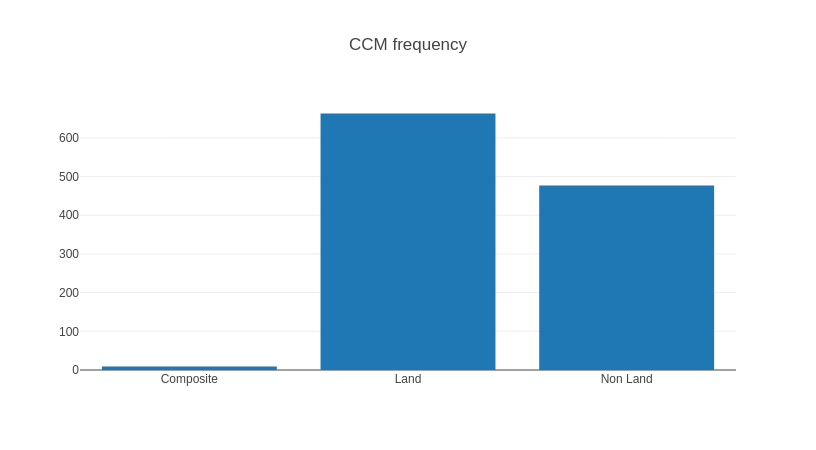

x: List[String] = List("Composite", "Land", "Non Land")
y: List[Int] = List(9, 663, 477)
res21_1: String = "plot-dab68f7e-08a9-46d3-947c-b76aef56795c"

In [22]:
val (x, y) = typeZeroCCM.toList.unzip
Bar(x, y).plot(title="CCM frequency")

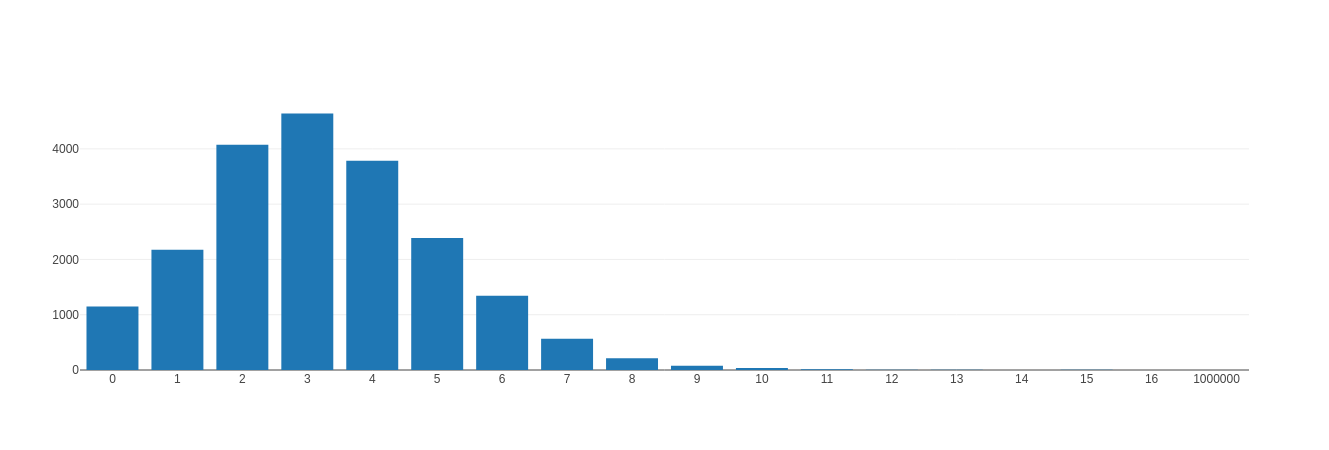

x: List[Int] = List(
  0,
...
y: List[Int] = List(
  1149,
...
layout: Layout = Layout(
  None,
...
res6_2: String = "plot-8f7d8073-d8b8-4515-be39-2d5613a7861a"

In [7]:
val (x, y) = distributionOfCCM.toList.sorted.unzip // Bar constructor needs two lists
val layout = Layout(xaxis = Axis(`type` = AxisType.Category)) // category axis because of the weird outliers
plot(List(Bar(x, y)), layout = layout)

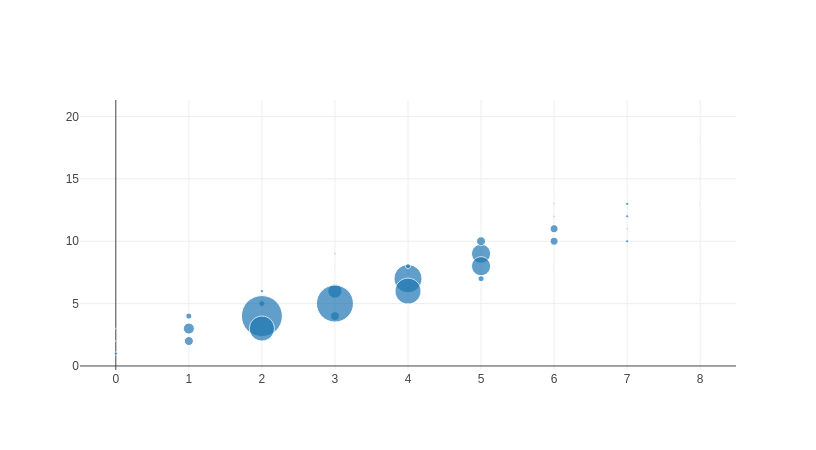

couplesToSize: Map[(Int, Int), Int] = Map(
  (2, 5) -> 6,
...
x: List[Int] = List(
  2,
...
y: List[Int] = List(
  5,
...
sizes: List[Int] = List(
  6,
...
res22_3: String = "plot-c2c89d18-f912-4dcb-a01f-accee80784ac"

In [23]:
val couplesToSize = statsVersusCCM
    .groupBy(x => x).mapValues(_.size)
    
val (x, y) = couplesToSize.keys.toList.unzip
val sizes = couplesToSize.values.toList
Scatter(
    x, y, 
    mode = ScatterMode(ScatterMode.Markers),
    marker = Marker(sizes)
).plot()